# Adversarial Attack and Detection in Medical Images using Deap Learning

## Imports
Import common libraries.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Partition data
Partition the data defined in a .csv file, where each row holds the file name of the images and their corresponding label, into three different .csv files; for training, validation and testing. You can specify the ratios of training, validation and test data sets as well as the output directory.

#### Settings

In [2]:
PARTITION = False                             # Set to false once data has been partitioned into .csv files

PARTITION_INPUT_FILE = 'data/data_labels.csv' # File with original images and labels
PARTITION_RATIOS = [0.70, 0.15, 0.15]         # Ratios of training, validation, and test data
PARTITION_UNIFORM = False                     # If to partition data and labels uniformly
PARTITION_OUT_PATH = 'data/2021-11-11/'       # Out path for .csv files for training, validation, and test data

#### Parition data into training, validation, and test data

In [3]:
from data import partition_data

if PARTITION:
    partition_data(input_file=PARTITION_INPUT_FILE,
                   ratios=PARTITION_RATIOS,
                   out_path=PARTITION_OUT_PATH,
                   uniform=PARTITION_UNIFORM)

## Import and transform data
Import the data for training and validation, and augment the images if wanted to. Also plot some examples of training and validation medical images.

#### Settings

In [4]:
IMAGE_SIZE = 128                           # Image size to resize images to
BATCH_SIZE = 16                            # Batch size to use
NUM_WORKERS = 4                            # Number of workers
IMAGE_ROOT = './data/data_images/'         # Path to images
PARTITION_PATH_ROOT = './data/2021-11-11/' # Path to .csv files with training, validation and test data sets

#### Import and transform data

In [5]:
import albumentations as album
from albumentations.pytorch import ToTensorV2
from data import LoadDatasetFromCSV
from torch.utils.data import DataLoader

# Resize images and rescale values
album_compose = album.Compose([
    album.Resize(IMAGE_SIZE, IMAGE_SIZE),                                          # Resize to IMAGE_SIZE x IMAGE_SIZE
    album.Normalize(mean=[0.0,0.0,0.0], std=[1.0,1.0,1.0], max_pixel_value=255.0), # Rescale values from [0,255] to [0,1]
    album.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5], max_pixel_value=1.0),   # Rescale values from [0,1] to [-1,1]
    ToTensorV2(),
])

# Load training and validation data set
dataset_train = LoadDatasetFromCSV(image_root=IMAGE_ROOT,
                                   csv_path=PARTITION_PATH_ROOT+'data_labels_train.csv',
                                   transforms=album_compose)
dataset_valid = LoadDatasetFromCSV(image_root=IMAGE_ROOT,
                                   csv_path=PARTITION_PATH_ROOT+'data_labels_validation.csv',
                                   transforms=album_compose)

# Load data into loaders
dataloader_train = DataLoader(dataset=dataset_train, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
dataloader_valid = DataLoader(dataset=dataset_valid, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

#### Plot some examples from training and validation data sets

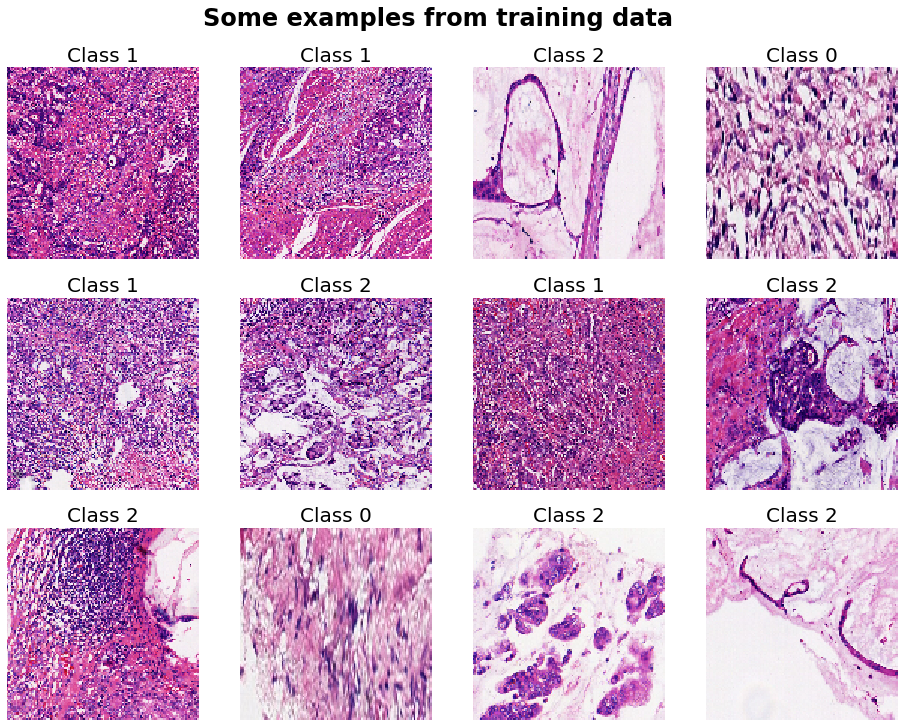

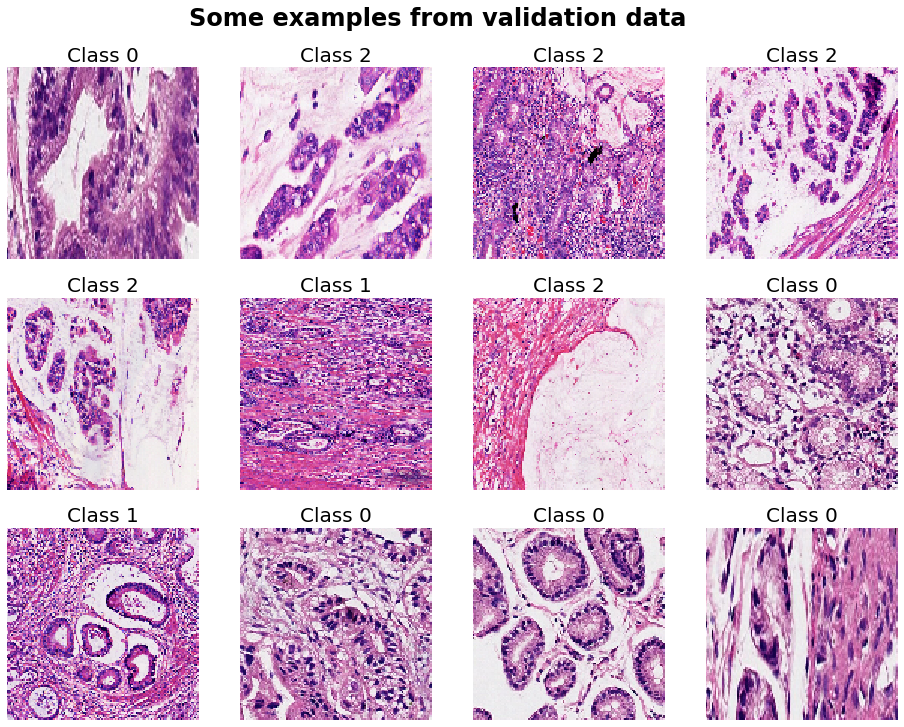

In [6]:
from plot import plot_dataloader

# Plot settings
rows, cols, width = 3, 4, 4

# Plot training data
fig, axs = plot_dataloader(dataloader_train, rows=rows, cols=cols, width=width)
fig.suptitle('Some examples from training data', fontsize=24, y=0.95, weight='bold')
plt.show()

# Plot validation data
fig, axs = plot_dataloader(dataloader_valid, rows=rows, cols=cols, width=width)
fig.suptitle('Some examples from validation data', fontsize=24, y=0.95, weight='bold')
plt.show()

## Train classifier

#### Settings

In [7]:
LOAD_MODEL = True

MODEL_NAME = 'efficientnet-b0'
NUM_CLASSES = 3
EPOCHS = 15
INIT_LR = 0.01
LOAD_PATH = './checkpoints/2021-11-11_128x128_15/models/best.pt'
SAVE_PATH = './checkpoints/2021-11-11_128x128_15'

#### Train classifier

In [8]:
import time
from datetime import datetime, timedelta
from utils import create_save_path
import classify
from models.efficientnet import EfficientNet
from torch.utils.tensorboard import SummaryWriter



best_monitor_value = 0



# Load trained model
if LOAD_MODEL:
    
    # Setup
    model = torch.load(LOAD_PATH)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    loss_function = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(lr=INIT_LR, params=model.parameters(), betas=(0.9, 0.99))
    
    # Print information
    print('Loaded model:', LOAD_PATH)

    

# Train model
else:
    
    # Setup device, model, loss function, and optimizer
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = EfficientNet.from_name(MODEL_NAME, num_classes=NUM_CLASSES)
    model.to(device)
    loss_function = torch.nn.CrossEntropyLoss()
    loss_function.to(device)
    optimizer = torch.optim.Adam(lr=INIT_LR, params=model.parameters(), betas=(0.9, 0.99))
    optimizer_step = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-5)

    # Create path for saving training log and models
    train_log_path, models_path = create_save_path(SAVE_PATH)

    # Initialize log writer
    log_writer = SummaryWriter(train_log_path, comment=f'LR_{INIT_LR}_BS_{BATCH_SIZE}')

    # Print starting time
    time_start = time.time()
    print('Started training:', str(datetime.now()))
    print('')
    
    # Train for each epoch
    for epoch in range(EPOCHS):
        
        # Print current epoch
        print('Epoch {:<3}'.format(epoch+1), end='   ')
        
        # Train model
        train_acc, train_loss = classify.train(dataloader_train, model, device, loss_function, optimizer)
        print('Training accuracy: {:>3}%, loss: {:<5}'.format(
            np.around(100*train_acc, 2), np.around(train_loss, 5)), end='   ')

        # Validate model
        valid_acc, valid_loss = classify.valid(dataloader_valid, model, device, loss_function, optimizer)
        print('Validation accuracy: {:>3}%, loss: {:<5}'.format(
            np.around(100*valid_acc, 2), np.around(valid_loss, 5)), end='\n')

        # Optimize
        optimizer_step.step()
        lr = optimizer.param_groups[0]['lr']

        # Save model if better than previously best model as well as the last model
        best_monitor_value = classify.save_model(model=model, epoch=epoch, best_monitor_value=best_monitor_value,
                                               monitor_value=valid_acc, epochs=EPOCHS, models_path=models_path)

        # Write to tensorboard log
        log_writer.add_scalar("Train/Training accuracy",   train_acc,  epoch)
        log_writer.add_scalar("Train/Validation accuracy", valid_acc,  epoch)
        log_writer.add_scalar("Train/Training loss",       train_loss, epoch)
        log_writer.add_scalar("Train/Validation loss",     valid_loss, epoch)
        log_writer.add_scalar("Train/Learning rate",       lr,         epoch)

    # Print time elapsed
    time_elapsed = time.time() - time_start
    print('')
    print('Ended:', str(datetime.now()))
    print('Total training time: {}'.format(str(timedelta(seconds=time_elapsed))))

Loaded model: ./checkpoints/2021-11-11_128x128_15/models/best.pt


## Test classifier

#### Test classifier

In [9]:
# Load test data
dataset_test = LoadDatasetFromCSV(image_root=IMAGE_ROOT,
                                  csv_path=PARTITION_PATH_ROOT+'data_labels_test.csv',
                                  transforms=album_compose)

# Load data into loaders
dataloader_test = DataLoader(dataset=dataset_test, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

# Test classifier
test_acc, test_loss, misclassified_images, misclassified_labels, correct_labels = \
    classify.test(dataloader_test, model, device, loss_function, optimizer)

print('Test accuracy:   '+str(np.around(100*test_acc,2))+'%')
print('Test loss:       '+str(np.around(test_loss,5)))

Test accuracy:   97.74%
Test loss:       0.08622


#### Plot misclassified examples

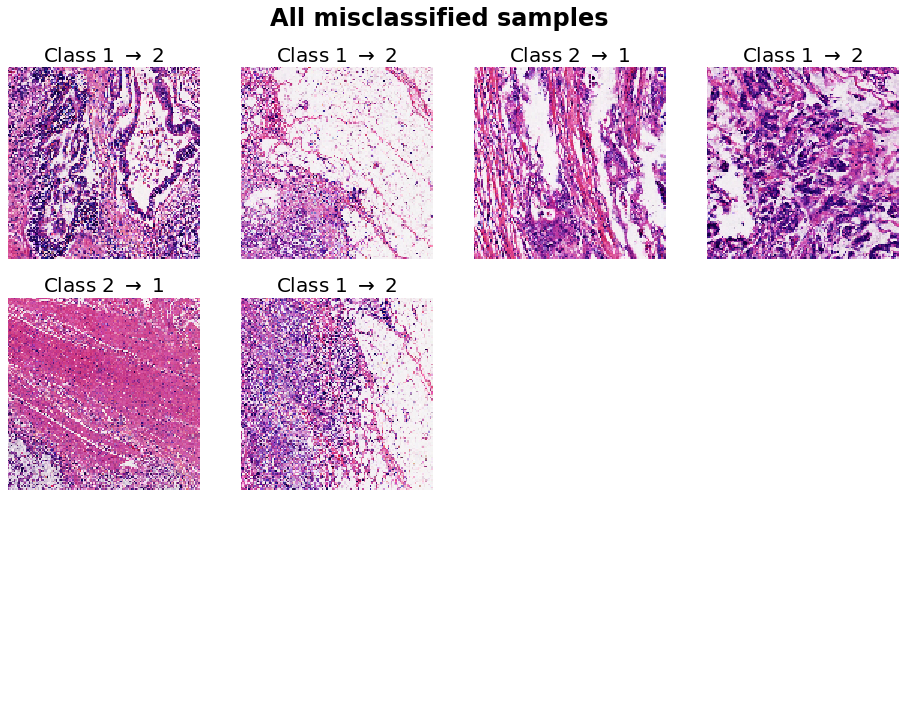

In [10]:
from plot import plot_images

# Plot settings
rows, cols, width = 3, 4, 4

# Plot training data
fig, axs = plot_images(misclassified_images, correct_labels, rows=rows, cols=cols, width=width,
                       predicted_labels=misclassified_labels)
fig.suptitle('All misclassified samples', fontsize=24, y=0.95, weight='bold')
plt.show()

## Attack

#### Settings

In [11]:
BATCH_SIZE = 1
SHUFFLE = True
EPSILON = 0.05
STEPS = 20
TARGETED = True
MAX_BATCHES = 10
ATTACK_METHOD = 'IFGSM'

#### Attack with FGSM or IFGSM

RESULTS OF ATTACKS
  True labels:              1 2 0 2 2 0 2 2 1 2
  Labels after attack:      2 0 2 1 1 1 0 0 2 0
  Wrong prediction:         x x x x x x x x x x
  Accuracy:                 0.0%

  True labels:              1 2 0 2 2 0 2 2 1 2
  Labels after attack:      2 0 2 1 1 1 0 0 2 0
  Targeted labels:          2 0 2 1 1 1 0 0 2 0
  Correct target:           o o o o o o o o o o
  Target accuracy:          100.0%

  Similarities:             [0.00362, 0.00223, 0.00317, 0.00321, 0.00395, 0.00105, 0.00233, 0.00317, 0.00269, 0.00246]
  Mean similarity:          0.0027867502067238092


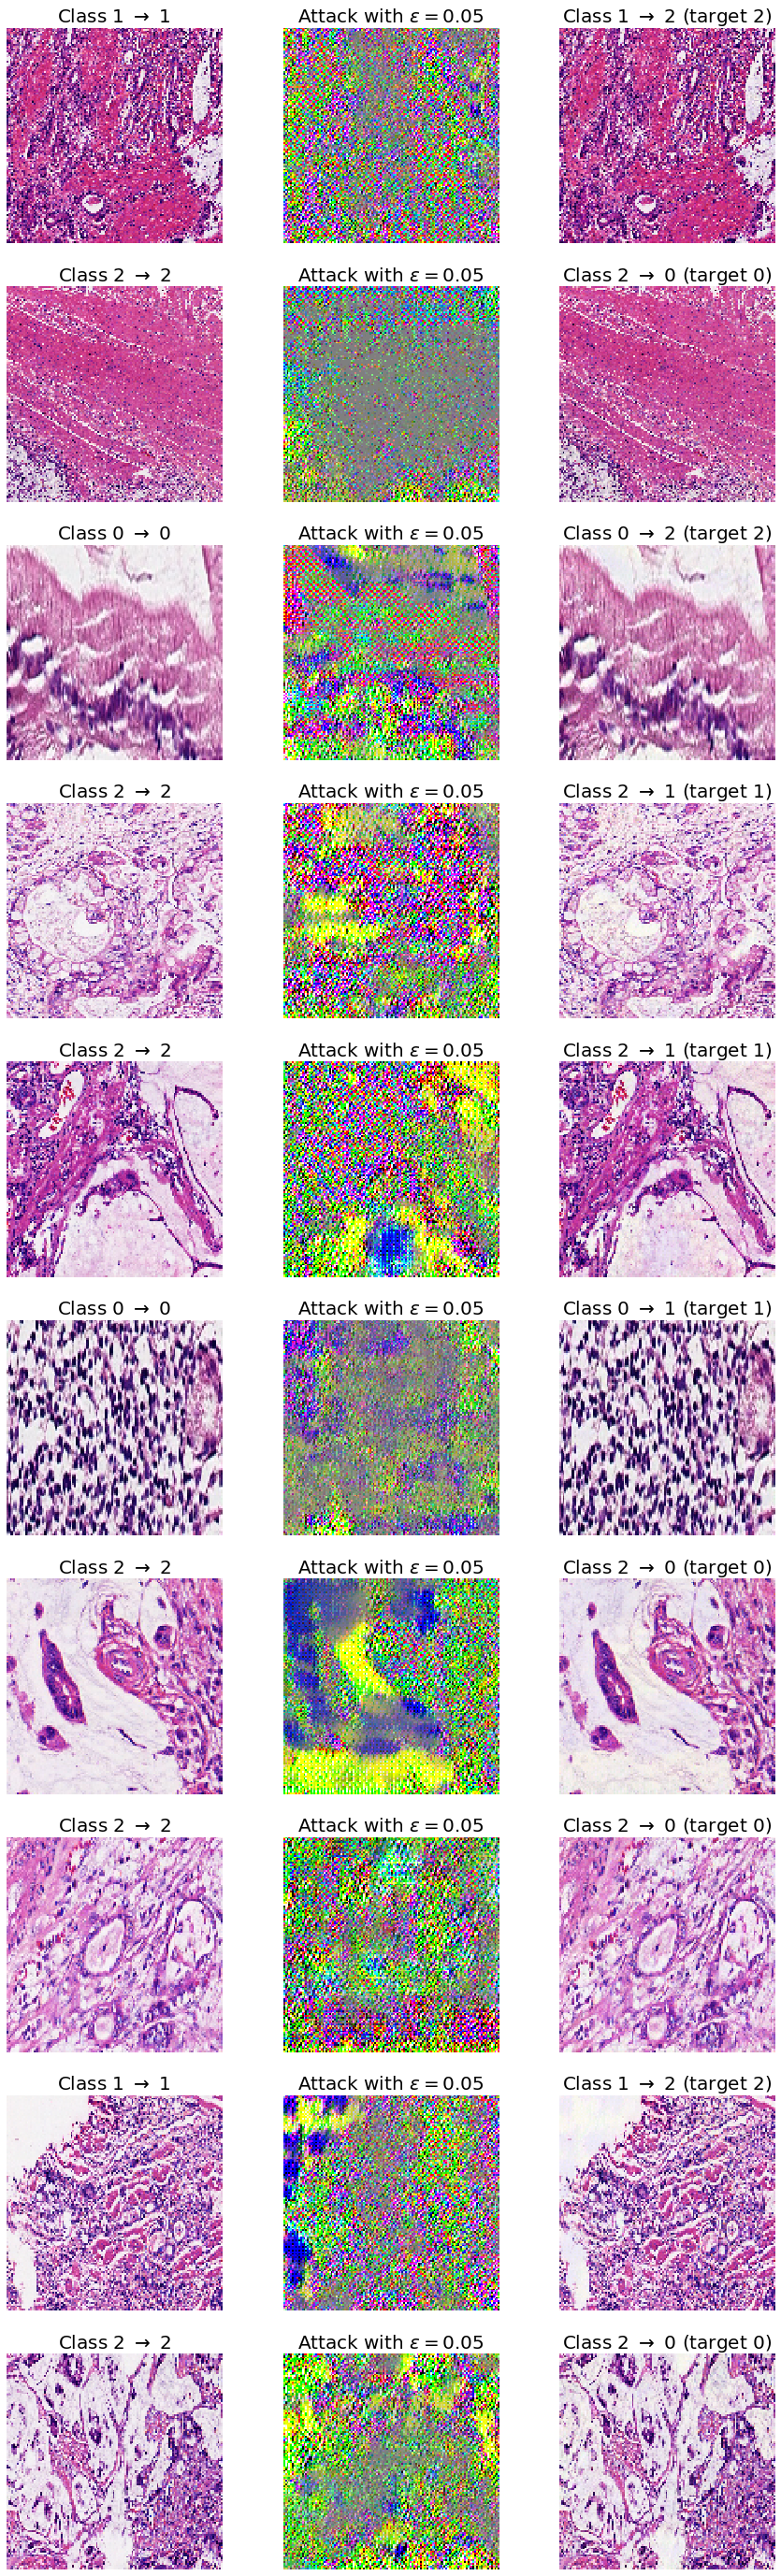

In [12]:
import attack
from plot import plot_attacks



# Load trained model
model = torch.load(LOAD_PATH)
    
# Load test data to attack
dataset_attack = LoadDatasetFromCSV(image_root=IMAGE_ROOT,
                                    csv_path=PARTITION_PATH_ROOT+'data_labels_test.csv',
                                    transforms=album_compose)

# Load data into loaders
dataloader_attack = DataLoader(dataset=dataset_attack, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

# Initialize and choose attacker
if ATTACK_METHOD == 'FGSM':
    attack_method = attack.FGSM(model=model, epsilon=EPSILON, targeted=TARGETED)
elif ATTACK_METHOD == 'IFGSM':
    attack_method = attack.IFGSM(model= model, epsilon=EPSILON, steps=STEPS, targeted=TARGETED)

    
# Intialize reults arrays
all_images = torch.Tensor()
all_labels = torch.Tensor().type(dtype=torch.uint8)
all_init_labels = torch.Tensor().type(dtype=torch.uint8)
all_attacked_images = torch.Tensor()
all_attacked_labels = torch.Tensor().type(dtype=torch.uint8)
all_gradients = torch.Tensor()
if TARGETED:
    all_targeted_labels = torch.Tensor().type(dtype=torch.uint8)
else:
    all_targeted_labels = None
all_similarities = torch.Tensor()


# Iterate over each batch
for batch, (images, labels) in enumerate(dataloader_attack):
    
    images = images['image']
    init_labels = model(images).max(1, keepdim=False)[1]

    # Attack images
    attacked_images, gradients, targeted_labels, similarities = attack_method.attack(images, labels)
    attacked_labels = model(attacked_images).max(1, keepdim=False)[1]
    
    # Concatenate results for each batch
    all_images = torch.cat((all_images, images), dim=0)
    all_labels = torch.cat((all_labels, labels), dim=0)
    all_init_labels = torch.cat((all_init_labels, labels), dim=0)
    all_attacked_images = torch.cat((all_attacked_images, attacked_images), dim=0)
    all_attacked_labels = torch.cat((all_attacked_labels, attacked_labels), dim=0)
    all_gradients = torch.cat((all_gradients, gradients), dim=0)
    if TARGETED:
        all_targeted_labels = torch.cat((all_targeted_labels, targeted_labels), dim=0)
    all_similarities = torch.cat((all_similarities, similarities), dim=0)

    # Stop if above max amount of batches to test for
    if MAX_BATCHES is None:
        MAX_BATCHES = len(loader_attack)
    if batch >= MAX_BATCHES - 1:
        break


# Evaluate attacks
attack.evaluate_attacks(model, all_labels, all_attacked_images, all_attacked_labels, targeted_labels=all_targeted_labels)
print('\n  Similarities:            ', [np.around(similarity.item(), 5) for similarity in all_similarities])
print('  Mean similarity:         ', torch.mean(all_similarities).item())

# Plot attacks
rows = 10
plot_attacks(rows, all_images, all_labels, all_init_labels, all_attacked_images, all_attacked_labels, all_gradients,
             epsilon=EPSILON, targeted_labels=all_targeted_labels)
plt.show()

In [13]:
# Save attacked images and original ones
attack.save_images(all_images, all_attacked_images, all_gradients, all_labels, all_attacked_labels)

Saving images and attacked images to ./attacked_images
Done.
